# Hill Climbing (with adaptive noise scaling, without tensors) 
# CartPole-v1

---

   In this notebook, we train the Hill Climbing Agent with   
**adaptive noise scaling** with OpenAI Gym's Cartpole environment.

### Policy-Based Method

In **policy-based methods**, instead of learning a **value function** that tells us what is     
the expected sum of rewards given a state and an action, we learn directly the **policy function**    
that maps state to action (select actions without using a value function).

### 1. Import the Necessary Packages

In [115]:
import gymnasium as gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
#%matplotlib inline
import time


### 2. Define the Policy

In [116]:
env = gym.make('CartPole-v1', render_mode="human")
print('observation space:', env.observation_space)
print('action space:', env.action_space)
threshold = env.spec.reward_threshold
print('threshold: ', threshold)

class Policy():
    def __init__(self, s_size=4, a_size=2):
        self.w = 1e-4*np.random.rand(s_size, a_size)  # weights for simple linear policy: state_space x action_space
        
    def forward(self, state):
        x = np.dot(state, self.w)
        return np.exp(x)/sum(np.exp(x))
    
    def act(self, state):
        probs = self.forward(state)
        # action = np.random.choice(2, p=probs) # option 1: stochastic policy
        action = np.argmax(probs)              # option 2: deterministic policy
        return action

observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: Discrete(2)
threshold:  475.0


### 3. Train the Agent with Deterministic Policy Search

In [117]:
# env.seed(0) deprecated, use env.reset(seed=0)
np.random.seed(0)

policy = Policy()

def hill_climbing(n_episodes=1000, gamma=0.99, print_every=100, noise_scale=1e-2):
    """Implementation of hill climbing with adaptive noise scaling.
        
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        noise_scale (float): standard deviation of additive noise
    """
    scores_deque = deque(maxlen=100)
    scores = []
    arr_noise = []
    best_Gt = -np.Inf
    best_w = policy.w
    for i_episode in range(1, n_episodes+1):
        rewards = []
        state, info = env.reset()
        timesteps = 0 ## is the same as len(rewards)
        
        while True:
            action = policy.act(state)
            state, reward, done, truncated, info = env.step(action)            
            rewards.append(reward)
            timesteps += 1  
            if done or truncated:
                break 
                
        total_reward = sum(rewards)        
        scores_deque.append(total_reward)
        scores.append(total_reward)

        discounts = [gamma**i for i in range(len(rewards)+1)]
        ## This is the 'cumulative discounted reward' or TD-target G_t
        Gt = sum([a*b for a,b in zip(discounts, rewards)])
        
        if Gt >= best_Gt: # found better weights
            ## if Gt > best_R ==> decrease the noise: noise = noise/2  (till 0.001)
            best_Gt = Gt
            best_w = policy.w
            noise_scale = max(1e-3, noise_scale / 2)
            print('Ep.: {:3d} , timesteps: {:3d}, noise_scale (Gt >= best(Gt)): {:.4f}, Gt {:.4f}, \tAvg.Score:  {:.3f}'\
                  .format(i_episode, timesteps, noise_scale, Gt, np.mean(scores_deque)))
            policy.w += noise_scale * np.random.rand(*policy.w.shape) 
        else: # did not find better weights
            ## if Gt < best_R ==> increase the noise: noise = 2*noise (till 2)
            noise_scale = min(2, noise_scale * 2)
            print('Ep.: {:3d} , timesteps: {:3d}, noise_scale (Gt < best(Gt)): {:.4f}, Gt {:.4f}, \tAvg.Score:  {:.3f}'\
                  .format(i_episode, timesteps, noise_scale, Gt, np.mean(scores_deque)))
            policy.w = best_w + noise_scale * np.random.rand(*policy.w.shape)
            
        arr_noise.append(noise_scale)   

        if np.mean(scores_deque)>=threshold:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            policy.w = best_w
            break
    
    return scores, arr_noise
            
scores, arr_noise = hill_climbing()

Ep.:   1 , timesteps: 182, noise_scale (Gt >= best(Gt)): 0.0050, Gt 83.9452, 	Avg.Score:  182.000
Ep.:   2 , timesteps:  78, noise_scale (Gt < best(Gt)): 0.0100, Gt 54.3390, 	Avg.Score:  130.000
Ep.:   3 , timesteps:  56, noise_scale (Gt < best(Gt)): 0.0200, Gt 43.0399, 	Avg.Score:  105.333
Ep.:   4 , timesteps:  10, noise_scale (Gt < best(Gt)): 0.0400, Gt 9.5618, 	Avg.Score:  81.500
Ep.:   5 , timesteps:  10, noise_scale (Gt < best(Gt)): 0.0800, Gt 9.5618, 	Avg.Score:  67.200
Ep.:   6 , timesteps:  45, noise_scale (Gt < best(Gt)): 0.1600, Gt 36.3815, 	Avg.Score:  63.500
Ep.:   7 , timesteps:   9, noise_scale (Gt < best(Gt)): 0.3200, Gt 8.6483, 	Avg.Score:  55.714
Ep.:   8 , timesteps:  10, noise_scale (Gt < best(Gt)): 0.6400, Gt 9.5618, 	Avg.Score:  50.000
Ep.:   9 , timesteps:   8, noise_scale (Gt < best(Gt)): 1.2800, Gt 7.7255, 	Avg.Score:  45.333
Ep.:  10 , timesteps:  24, noise_scale (Gt < best(Gt)): 2.0000, Gt 21.4322, 	Avg.Score:  43.200
Ep.:  11 , timesteps:   9, noise_scale (G

KeyboardInterrupt: 

### 4. Plot the Scores

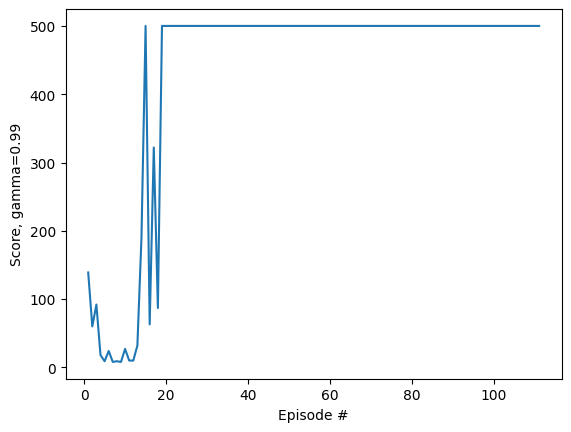

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score, gamma=0.99')
plt.xlabel('Episode #')
plt.show()

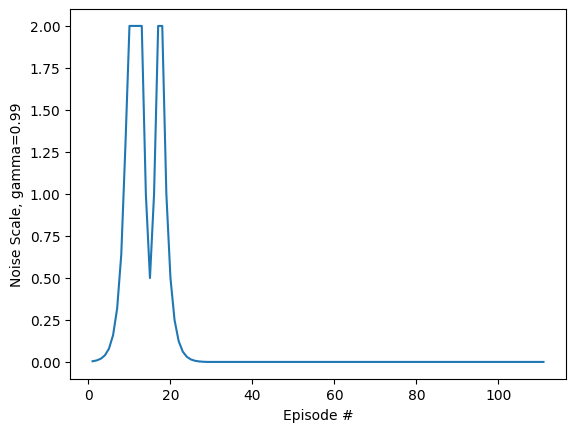

In [6]:
ax2 = fig.add_subplot(121)
plt.plot(np.arange(1, len(arr_noise)+1), arr_noise)
plt.ylabel('Noise Scale, gamma=0.99')
plt.xlabel('Episode #')
plt.show()